<a href="https://colab.research.google.com/github/limyewjin/llm-tutorial/blob/main/Prompt_Engineering_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interactive Prompt Engineering Tutorial

**Author**: [Yew Jin Lim](https://www.linkedin.com/in/yewjinlim/)

**Github link**: https://github.com/limyewjin/llm-tutorial

**Last Significant Update**: Dec, 2024

## Disclaimer

Two important caveats for this tutorial:

1. **Indeterministic Behavior**: LLMs may produce different outputs even with identical inputs. While these exercises have been tested to work consistently, you may occasionally get unexpected results. This variability is not a bug - it's inherent to how these models work.

2. **Evolving Capabilities**: The capabilities and limitations described here reflect what models can do as of December 2024. As AI advances rapidly, some techniques may become obsolete while new ones emerge.

*Note: Examples have been tested with Google's Gemini models. Results may vary with other LLMs.*

(Based heavily on prompt tutorials from Gemini, Anthropic, and OpenAI, see resources section below for links to those resources)

# DO THIS FIRST!
You'll need an API key for Gemini. If you don't already have one, create a key in Google AI Studio.

<a class="button" href="https://aistudio.google.com/app/apikey" target="_blank" rel="noopener noreferrer">Get an API key</a>

In Colab, add the key to the secrets manager under the "🔑" in the left panel. Give it the name `GEMINI_API_KEY`. Then pass the key to the SDK.

## Run all cells to start! Helps to reset the exercises.

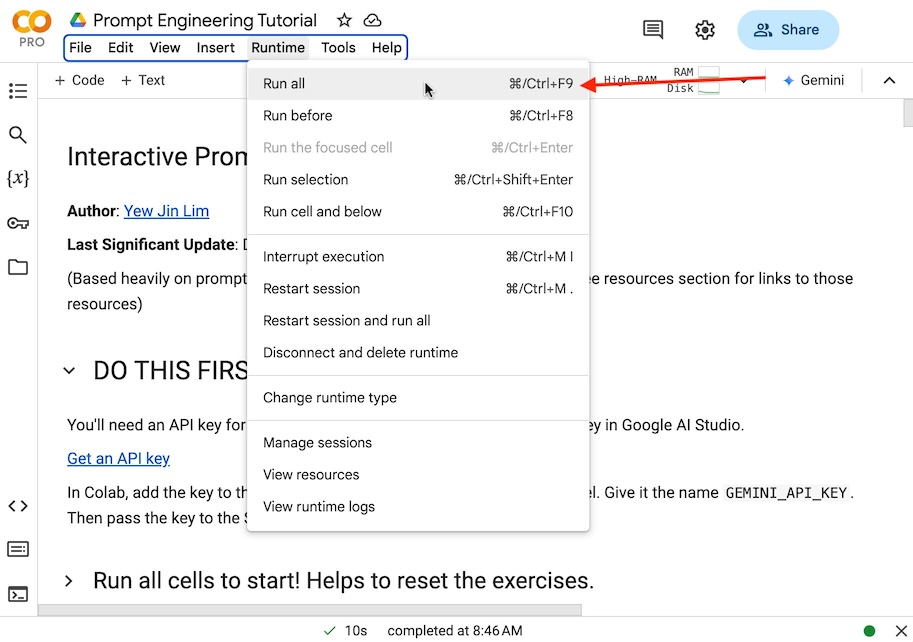

In [2]:
# @title Code setup

import google.generativeai as genai
import ipywidgets as widgets
import re
import textwrap
from xml.sax.saxutils import escape as xml_escape
from IPython.display import display, HTML, Markdown

from google.colab import userdata
GEMINI_API_KEY=userdata.get('GEMINI_API_KEY')
genai.configure(api_key=GEMINI_API_KEY)

# Update this to new models if available
# INFERENCE is used to generate answers
# EVALUATION is used to evaluate the answers produced for correctness
INFERENCE_MODEL_NAME="gemini-2.0-flash-exp"
EVALUATION_MODEL_NAME="gemini-2.0-flash-thinking-exp-01-21"

INFERENCE_MODEL = genai.GenerativeModel(INFERENCE_MODEL_NAME)
EVALUATION_MODEL = genai.GenerativeModel(EVALUATION_MODEL_NAME)

# Helper functions

# Get prompt and print out response
def print_response(response):
  paragraphs = response.text.split('\n')

  # Wrap each paragraph separately
  wrapped_paragraphs = [textwrap.fill(p.replace('\n', ' '), width=80)
                       for p in paragraphs]

  print('\n'.join(wrapped_paragraphs))

def generate_and_print(model, prompt):
  response = model.generate_content(prompt)
  print_response(response)
  return response

def generate_and_output_markdown(model, prompt):
  response = model.generate_content(prompt)
  display(Markdown(xml_escape(response.text)))
  display(Markdown('---'))
  return response

# Get input from the user
def default_button_fn(_, textarea):
  display(Markdown('**Output**:'))
  prompt = textarea.value
  generate_and_print(INFERENCE_MODEL, prompt)

def markdown_button_fn(_, textarea):
  display(Markdown('**Output**:'))
  prompt = textarea.value
  generate_and_output_markdown(INFERENCE_MODEL, prompt)

def markdown_button_with_criteria_fn(_, textarea, criteria):
  display(Markdown('**Output**:'))
  prompt = textarea.value
  response = generate_and_output_markdown(INFERENCE_MODEL, prompt)
  check_response(criteria, response)
  display(Markdown('---'))

def markdown_on_button_click_with_criteria_fn_fn(_, textarea, criteria_fn):
  display(Markdown('**Output**:'))
  prompt = textarea.value
  response = generate_and_output_markdown(INFERENCE_MODEL, prompt)
  criteria_fn(response)
  display(Markdown('---'))

def on_button_click_with_question_fn(_, question_textarea, prompt_textarea):
  #print(f"Question: {question_textarea.value}")
  prompt = prompt_textarea.value.format(user_question=question_textarea.value)
  display(Markdown('**Prompt**:'))
  print(prompt)
  display(Markdown('**LLM Response**:'))
  generate_and_print(INFERENCE_MODEL, prompt)

def markdown_on_button_click_with_question_criteria_fn(_, question_textarea, prompt_textarea, criteria):
  #print(f"Question: {question_textarea.value}")
  display(Markdown('**Prompt**:'))
  prompt = prompt_textarea.value.format(user_question=question_textarea.value)
  print(prompt)
  display(Markdown('**LLM Response**:'))
  response = generate_and_output_markdown(INFERENCE_MODEL, prompt)
  check_response(criteria, response)
  display(Markdown('---'))

def markdown_on_button_click_with_question_criteria_fn_fn(_, question_textarea, prompt_textarea, criteria_fn, print_question=True):
  #print(f"Question: {question_textarea.value}")
  prompt = prompt_textarea.value.format(user_question=question_textarea.value)
  if print_question:
    display(Markdown('**Prompt**:'))
    print(prompt)
  else:
    display(Markdown('**Prompt**:'))
    print(prompt_textarea.value)
  display(Markdown('**LLM Response**:'))
  response = generate_and_output_markdown(INFERENCE_MODEL, prompt)
  criteria_fn(response)
  display(Markdown('---'))


def get_user_prompt(instructions,
                    initial_prompt,
                    on_button_click_fn=default_button_fn,
                    prompt_placeholder='Enter prompt here...',
                    button_description='Get LLM Response',
                    prompt_height='100px'):
  if instructions:
    display(Markdown(instructions))
    print()

  textarea = widgets.Textarea(
      value=initial_prompt,
      placeholder=prompt_placeholder,
      description='Prompt:',
      layout=widgets.Layout(width='50%', height=prompt_height)
  )

  button = widgets.Button(
      description=button_description,
      button_style='success'
  )

  #def on_button_click_fn(_, textarea):
  #    print("Textarea content:")
  #    print(textarea.value)

  button.on_click(lambda b: on_button_click_fn(b, textarea))

  # Display the widgets
  vbox = widgets.VBox([textarea, button])
  display(vbox)

def get_user_prompt_with_user_question(instructions,
                                       initial_question,
                                       initial_prompt,
                                       on_button_click_fn=on_button_click_with_question_fn,
                                       prompt_placeholder='Enter prompt here...',
                                       button_description='Get LLM Response',
                                       question_height='25px',
                                       prompt_height='100px'):
  if instructions:
    display(Markdown(instructions))
    print()

  question_textarea = widgets.Textarea(
      value=initial_question,
      placeholder='Enter user question here...',
      description='Question:',
      layout=widgets.Layout(width='50%', height=question_height)
  )

  prompt_textarea = widgets.Textarea(
      value=initial_prompt,
      placeholder=prompt_placeholder,
      description='Prompt:',
      layout=widgets.Layout(width='50%', height=prompt_height)
  )

  button = widgets.Button(
      description=button_description,
      button_style='success'
  )

  button.on_click(lambda b: on_button_click_fn(b, question_textarea, prompt_textarea))

  # Display the widgets
  vbox = widgets.VBox([question_textarea, prompt_textarea, button])
  display(vbox)

def check_response(criteria, response):
  print("Evaluating. This might take a while...", end='')

  #print(f"Criteria: {textwrap.fill(criteria, width=80)}")
  #print("Response provided:")
  #print(f"{textwrap.fill(response.text, width=80)}")
  check_answer = EVALUATION_MODEL.generate_content(f"""
You are evaluating the quality of a Large Language Model (LLM) response to a given criteria.

**Context:**

* The response is generated by an LLM.
* The user provided instructions or a "prompt" to guide the LLM's response.
* The goal of the prompt was to elicit a response that meets specific criteria.

**Instructions:**

1. **Analyze the Criteria:** Carefully read and understand the criteria that the LLM response is expected to meet. This may include constraints on format, content, style, etc.
2. **Evaluate the Response:**  Assess the LLM's response based on the following:
    * **Adherence to Criteria:** Does the response fully and accurately meet all the specified criteria?
    * **Completeness:** Does the response provide all necessary information or elements implied by the criteria?
3. **Determine Pass/Fail:** Based on your evaluation, determine if the response PASSes or FAILs. A response should PASS only if it meets ALL the criteria above.
4. **Explain Your Reasoning:** Provide a detailed explanation of your evaluation in the `<thinking>` tag, referencing specific examples from the response to support your judgment.  Clearly explain how the response meets or fails to meet each criterion.
5. **Provide Your Evaluation:**  State your final evaluation (PASS or FAIL) in the `<evaluation>` tag.

**Example 1:**

**Criteria:**  Generate a list of five fruits.

**LLM Response:**  Apple, banana, orange, grape, pear

<thinking>The response provides a list of five fruits as requested. It adheres to the criteria, is complete, clear, and coherent.</thinking>
<eval>PASS</eval>

**Example 2:**

**Criteria:**  Write a short story in exactly 100 words.

**LLM Response:**  (A story with 105 words)

<thinking>While the response provides a short story, it fails to adhere to the specific criteria of being exactly 100 words. It is therefore incomplete.</thinking>
<evaluation>FAIL</evaluation>


---

Below is the actual criteria and LLM response:

**Criteria**: {criteria}
**LLM Response**: {response.text}

Output Format:
<thinking>Thoughts</thinking>
<eval>PASS</eval> or <eval>FAIL</eval>
""".strip())

  print("Results:")
  thinking = re.search("<thinking>(.*)?</thinking>", check_answer.text, re.DOTALL).group(1).strip()
  display(Markdown(thinking))

  eval_answer = re.search("<eval>(.*)?</eval>", check_answer.text, re.DOTALL).group(1).strip()

  if eval_answer.lower() == "pass":
    display(HTML('<span style="color: white; background-color: green">PASS</span>'))
  else:
    display(HTML('<span style="color: white; background-color: red">FAIL</span>'))

def show_answer(answer, description="Show Answer"):
  answer_area = widgets.Output()
  button = widgets.Button(description=description)

  def show_answer(button):
   with answer_area:
     display(widgets.HTML(value=f'<div style="color: white; background-color: grey">{answer}</div>'))

  button.on_click(show_answer)

  display(button)
  display(answer_area)

# Chapter 1. Make your first requests

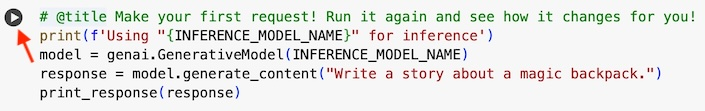

In [3]:
# @title Make your first request! Run it again and see how it changes for you!
print(f'Using "{INFERENCE_MODEL_NAME}" for inference')
model = genai.GenerativeModel(INFERENCE_MODEL_NAME)
response = model.generate_content("Write a story about a magic backpack.")
print_response(response)

Using "gemini-2.0-flash-exp" for inference
Maya wasn't known for her punctuality. More often than not, she was scrambling,
rushing, and arriving just as the bell shrieked its high-pitched song. One
Tuesday morning, while late for school *again*, she stumbled upon a curious
sight in the alleyway behind her apartment building. It was a backpack, nestled
amidst overflowing garbage bins and discarded cardboard boxes.

It wasn't just any backpack. This one shimmered with an almost imperceptible
inner light, its worn leather etched with swirling, unfamiliar symbols.
Intrigued, and with a quick glance to make sure no one was watching, Maya
snatched it up. It felt strangely light, almost empty.

That day, Maya arrived in class... on time. She couldn't explain it. Maybe she'd
just been super motivated. She shrugged and slipped the backpack onto the back
of her chair. As the teacher started droning on about fractions, Maya felt a
strange vibration coming from the bag. She peeked inside. It was e

## Explaining the code

```
print(f'Using "{INFERENCE_MODEL_NAME}" for inference')
model = genai.GenerativeModel(INFERENCE_MODEL_NAME)
response = model.generate_content("Write a story about a magic backpack.")
print_response(response)
```

1. **Initializes the model**: `genai.GenerativeModel(INFERENCE_MODEL_NAME)` sets up the Gemini model. As of this writing, `INFERENCE_MODEL_NAME` is `gemini-2.0-flash-exp`. You can use other [Gemini models](https://ai.google.dev/gemini-api/docs/models/gemini) such as `gemini-1.5-pro`

2. **Generating the content**: `Generates content: model.generate_content(...)` sends the story prompt to the model.

3. **Prints the response**: `print_response(response)` is a custom function that displays the generated story, but it's really just `print(response.text)`

## LLM Responses are non-deterministic

Did you run the magic backpack prompt above a few times? Did you notice that the response is non-deterministic? i.e., the results change everytime you run it?

As it turns out, it's not that TensorFlow or GPUs are inherently non-deterministic, but that all those floating point operations running asynchronously make the outputs non-deterministic. See [Determinism in Deep Learning (GTC 2019 Nvidia presenation)](https://developer.download.nvidia.com/video/gputechconf/gtc/2019/presentation/s9911-determinism-in-deep-learning.pdf)

For now, non-determinism is the expected behavior of LLMs.

# How the rest of the colab works
Now let's take a look at how Gemini responds to prompts and not worry about how the code works.

To be clear we merely abstracted the code so that all you have to enter is the prompt or user question. Refer back to the "Make your first request!" cell above and inspect the (simple) code. Effectively we're just passing the strings (and sometimes pre-processing them)!

Click on **Get LLM Response** to get the output from Gemini.

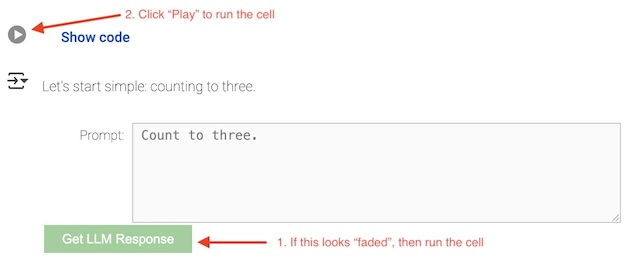

**Remember: Easiest way to reset this tutorial and start is `Runtime` > `Run all`**

In [4]:
# @title
get_user_prompt("Let's start simple: counting to three.", 'Count to three.')

Let's start simple: counting to three.

## ☝️ Try new prompts

Now go back above and edit the prompt to get the model to count to 10!

And then backwards from 10 to 1!

In [5]:
# @title Dynamic prompts
instructions = """Prompts can be dynamic! Let's construct a prompt that takes in another variable.

In this case, the question will be passed in to the prompt.

Try the following:
  1. Different questions and see how the response changes! ("How big is the moon?")
  2. Try changing the Prompt to pretend to be a different age and see how the response changes!
    - e.g., "Respond to questions and requests like you are a grumpy 80 year old man."
""".strip()

initial_question = "How big is the sky?"

initial_prompt = """
Respond to questions and requests like you are a 3 year old child.

User: {user_question}
""".strip()

get_user_prompt_with_user_question(
  instructions,
  initial_question,
  initial_prompt
)

Prompts can be dynamic! Let's construct a prompt that takes in another variable.

In this case, the question will be passed in to the prompt.

Try the following:
  1. Different questions and see how the response changes! ("How big is the moon?")
  2. Try changing the Prompt to pretend to be a different age and see how the response changes!
    - e.g., "Respond to questions and requests like you are a grumpy 80 year old man."

# Chapter 2 - Write clear instructions

LLMs responds best to clear and direct instructions.

Think of LLMs like any other human that is new to the job. LLMs has no context on what to do aside from what you literally tell it. Just as when you instruct a human for the first time on a task, the more you explain exactly what you want in a straightforward manner to the LLM, the better and more accurate the LLM's response will be.

If outputs are too long, ask for brief replies. If outputs are too simple, ask for expert-level writing. If you dislike the format, demonstrate the format you’d like to see. The less the model has to guess at what you want, the more likely you’ll get it.

## Clear Instructions Tactic 1: Include details in your query to get more relevant answers
In order to get a highly relevant response, make sure that requests provide any important details or context. Otherwise you are leaving it up to the model to guess what you mean.

| Worse | Better |
| ----- | ------ |
| Who’s president? |	Who was the president of Mexico in 2021, and how frequently are elections held? |
| Write code to calculate the Fibonacci sequence.	| Write a TypeScript function to efficiently calculate the Fibonacci sequence. Comment the code liberally to explain what each piece does and why it's written that way. |
| Summarize the meeting notes. | Summarize the meeting notes in a single paragraph. Then write a markdown list of the speakers and each of their key points. Finally, list the next steps or action items suggested by the speakers, if any. |





### Exercise 1: Include a preamble for a haiku

Below is a prompt to write a haiku about robots.

Here's a few exercises to try:
1. Get the model to include a preamble (e.g., "This is a haiku: ...")

2. Make the preamble specifically "This is a special haiku for my fellow robots: ..."


In [6]:
# @title
def check_haiku_response(response):
  print("Looking for preamble")
  success = response.text.lower().startswith("this is a haiku:") or response.text.lower().startswith("this is a special haiku for my fellow robots:")
  if success:
    display(HTML('<span style="color: white; background-color: green">PASS</span>'))
  else:
    display(HTML('<span style="color: white; background-color: red">FAIL</span>'))
  return success

get_user_prompt("""
""".strip(),
"Write a haiku about robots.",
  on_button_click_fn = (
  lambda b, t: (
      markdown_on_button_click_with_criteria_fn_fn(
          b,
          t,
          check_haiku_response)
    )
  ),
  button_description='Test LLM Response!'
)

show_answer("""
<ol>
<li>Write a haiku about robots. Have a preamble before you say anything else that says it is a haiku</li>
<li>Write a haiku about robots. Have a preamble before you say anything else that says: "This is a special haiku for my fellow robots:"</li>
</ol>
""".strip())

Button(description='Show Answer', style=ButtonStyle())

Output()

### Exercise 2: Get Gemini to make up its mind and decide on a best player

Here's another exercise. Let's ask Gemini who's the best basketball player of all time.

Try running it -- while Gemini lists a few names, it doesn't respond with a definitive "best".

The exercise is to provide instructions such that Gemini will decide and return only a single best basketball player of all time.

In [7]:
# @title
get_user_prompt(
"**Hint**: Just ask!",

"Who is the best basketball player of all time?",

on_button_click_fn = (
  lambda b, t: (
      markdown_button_with_criteria_fn(
          b,
          t,
          "Return PASS only if there is **only one** best basketball player of all time listed, do not worry about which player specifically. The only criteria is that there is only one player named as the best player.")
    )
  ),

button_description='Test LLM Response!'
)

show_answer("Who is the best basketball player of all time? You have to decide on a single player as the best")

**Hint**: Just ask!

Button(description='Show Answer', style=ButtonStyle())

Output()

## Clear Instructions Tactic 2: Use delimiters to clearly indicate distinct parts of the input (and output)

Delimiters like triple quotation marks, XML tags, section titles, etc. can help demarcate sections of text to be treated differently.

Triple quotes:
```
Summarize the text delimited by triple quotes with a haiku.

"""insert text here"""
```

XML tags:
```
You will be provided with a pair of articles (delimited with XML tags) about
the same topic. First summarize the arguments of each article. Then indicate
which of them makes a better argument and explain why.
USER
<article> insert first article here </article>

<article> insert second article here </article>
```

Section headers:
```
You will be provided with a thesis abstract and a suggested title for it. The
thesis title should give the reader a good idea of the topic of the thesis but
should also be eye-catching. If the title does not meet these criteria, suggest
5 alternatives.

Abstract: insert abstract here

Title: insert title here
```

For straightforward tasks such as these, using delimiters might not make a difference in the output quality. However, the more complex a task is the more important it is to disambiguate task details. Don't make the model work to understand exactly what you are asking of them.

### Exercise: Extract the second item on a list

Below is a prompt which as currently implemented causes Gemini to incorrectly interpret which part of the prompt is the instruction vs the input.

Update the prompt with delimiters for the input so that the model can correctly extract the second item on the list.

In [8]:
# @title
def check_list_extraction_response(response):
  print("Looking for 'This is about sheep baa-ing.' in response")
  success = "this is about sheep baa-ing." in response.text.lower()
  if success:
    display(HTML('<span style="color: white; background-color: green">PASS</span>'))
  else:
    display(HTML('<span style="color: white; background-color: red">FAIL</span>'))
  display(Markdown('---'))
  return success

initial_list = """
- This is an item about cows moo-ing.
- This is about sheep baa-ing.
- This is about pigs oink-ing.
""".strip()

initial_prompt = """
Below is a list of sentences. Tell me the second item on the list.

- Each is about an animal, like rabbits.
{user_question}
""".strip()

get_user_prompt_with_user_question(
  "",
  initial_list,
  initial_prompt,
  on_button_click_fn = (
  lambda b, q, t: (
      markdown_on_button_click_with_question_criteria_fn_fn(
          b,
          q,
          t,
          check_list_extraction_response)
    )
  ),
  question_height='60px',
  button_description='Test LLM Response!'
)

show_answer("""
Below is a list of sentences. Return the second item on the list.<br/>
- Each is about an animal, like rabbits.<br/>
{{<br/>
  "sentences": "{user_question}"<br/>
}}<br/>
<i>OR</i><br/>
Below is a list of sentences. Return the second item on the list.<br/>
- Each is about an animal, like rabbits.<br/>
&lt;sentences&gt;{user_question}&lt;/sentences&gt;
""".strip())

Button(description='Show Answer', style=ButtonStyle())

Output()

## Clear Instructions Tactic 3: Allow the model to think and specify the steps required to complete a task
Some tasks are best specified as a sequence of steps. Writing the steps out explicitly can make it easier for the model to follow them.

```
Use the following step-by-step instructions to respond to user inputs.

Step 1 - The text will be provided in triple quotes. Summarize this text in one sentence with a prefix that says "Summary: ".

Step 2 - Translate the summary from Step 1 into Spanish, with a prefix that says "Translation: ".

"""insert text here"""
```

Another common prompt engineering tactic is to ask the model to ["Think step-by-step"](https://arxiv.org/abs/2205.11916) first before answering. Give the model time and space to "think" though using delimiters above (e.g., JSON, triple quotes, XML tags, etc.)

```
A pet store had 64 puppies. In one day they sold 63 of them and
put the rest into cages with 4 in each cage. How many cages did
they user? Think step-by-step.
```

(Try the above in [aistudio.google.com](https://aistudio.google.com/) with and without "Think step-by-step" for Gemini models.)

### Exercise: Allow Gemini to think things out first before answering

```What is the number of Is combined in the words "supercalifragilisticexpialidocious" and "intelligence"?```

It might take a while but as humans we can eventually figure out that it's 9. We'll cover why this is hard for a model next but for now improve the prompt by breaking down the thought process before answering.

**Caveat**: The simple initial prompt works occasionally, and vice-versa that the answer prompt doesn't occasionally too!






In [20]:
# @title
get_user_prompt("""
""".strip(),
"""What is the number of Is combined in the words "supercalifragilisticexpialidocious" and "intelligence"?
""".strip(),
  on_button_click_fn = (
  lambda b, t: (
      markdown_button_with_criteria_fn(
          b,
          t,
          "Return PASS only if the model's answer is that number of Is is 9. The exact phrasing is not important.")
    )
  ),
  button_description='Test LLM Response!',
  prompt_height='200px'
)

show_answer("""
What is the number of Is combined in the words "supercalifragilisticexpialidocious" and "intelligence"?<br/>
Think step-by-step by spelling it out and then counting one-by-one.
""".strip())

Button(description='Show Answer', style=ButtonStyle())

Output()

**Output**:

Let's count the number of "i"s in each word:

*   **supercalifragilisticexpialidocious:** There are three "i"s.
*   **intelligence:** There are three "i"s.

Adding those together, 3 + 3 = 6.

So the total number of "i"s is 6.

---

Evaluating. This might take a while...Results:


The criteria states that the response should return PASS only if the model's answer is that the number of Is is 9.
The LLM response calculates the number of 'i's in two words: "supercalifragilisticexpialidocious" and "intelligence".
It incorrectly counts 3 'i's in "supercalifragilisticexpialidocious" when there are actually 9.
It incorrectly counts 3 'i's in "intelligence" when there are actually 2.
Based on these incorrect counts, it concludes that the total number of 'i's is 6.
Since the model's answer is that the number of 'i's is 6, and the criteria requires the answer to be 9 for a PASS, the response fails to meet the criteria.
Therefore, the evaluation should be FAIL.

---

**Output**:

Okay, let's break this down:

**1. supercalifragilisticexpialidocious**

*   s u p e r c a l **i** f r a g **i** l **i** s t **i** c e x p **i** a l **i** d o c **i** o u s

Counting the "i"s, we have: 7

**2. intelligence**

*   **i** n t e l l **i** g e n c e

Counting the "i"s, we have: 2

**3. Sum**

*   7 + 2 = 9

Therefore, there are a total of **9** "i"s in the two words combined.


---

Evaluating. This might take a while...Results:


The criteria states that the LLM response should return PASS only if the model's answer is that the number of Is is 9.
The LLM response breaks down the counting of 'i's in "supercalifragilisticexpialidocious" and "intelligence".
It correctly counts 7 'i's in "supercalifragilisticexpialidocious" and 2 'i's in "intelligence".
It then sums these counts to arrive at 9.
The response concludes with "Therefore, there are a total of **9** 'i's in the two words combined."
The LLM's answer is indeed that the number of 'i's is 9.
Therefore, the response meets the criteria for a PASS.

---

#### Why is it so hard to count the number of Rs in 'Strawberry'?

A quick way to understand why LLMs struggle to count letters is that they don't see words as we do. Take "strawberry" - while we see it as individual letters, LLMs see it broken into tokens, more like "🌾" (straw) + "🫐" (berry). This tokenization means the word gets split into chunks, making it hard to count individual letters like 'r' since they might end up in different tokens.

In effect, this means that

`"What is the number of Rs in 'strawberry'"` looks more like:

`"❓#️⃣®️🌾🫐"`!

 That's a bit harder than it looks, yeah?



## Clear Instructions Tactic 4: Provide examples

Providing general instructions that apply to all examples is generally more efficient than demonstrating all permutations of a task by example, but in some cases providing examples may be easier. For example, if you intend for the model to copy a particular style of responding to user queries which is difficult to describe explicitly. This is known as "few-shot" prompting.

```
Answer in a consistent style.

Example:
USER: Teach me about patience.
ASSISTANT: The river that carves the deepest valley flows from a modest spring;
the grandest symphony originates from a single note; the most intricate
tapestry begins with a solitary thread.

USER: Teach me about the ocean.
```

### Exercise: Providing examples can sometimes be easier than giving instructions

The goal is to build a "parent bot" that responds to questions from kids. Gemini's default response is quite formal and robotic. This is going to break a child's heart.

You could take the time to describe your desired tone, but it's much easier just to give Gemini a few examples of ideal responses.

In [10]:
# @title
get_user_prompt(
"",

"User: Will Santa bring me presents on Christmas?",

on_button_click_fn = (
  lambda b, t: (
      markdown_button_with_criteria_fn(
          b,
          t,
          "Return PASS only if the response is like a parent talking to their young child and keeping their belief in Santa.")
    )
  ),

button_description='Test LLM Response!',
prompt_height='200px'
)

show_answer("""
User: Please complete the conversation by writing the next line, speaking as "A".<br/>
Q: Is the tooth fairy real?<br/>
A: Of course, sweetie. Wrap up your tooth and put it under your pillow tonight. There might be something waiting for you in the morning.<br/>
Q: Will Santa bring me presents on Christmas?""".strip())

Button(description='Show Answer', style=ButtonStyle())

Output()

## Clear Instructions Tactic 5: Specify the desired length of the output
You can ask the model to produce outputs that are of a given target length. The targeted output length can be specified in terms of the count of words, sentences, paragraphs, bullet points, etc. Note however that instructing the model to generate a specific number of words does not work with high precision. The model can more reliably generate outputs with a specific number of paragraphs or bullet points.

```
Summarize the text delimited by triple quotes in about 50 words.

"""insert text here"""
```

```
Summarize the text delimited by triple quotes in 2 paragraphs.

"""insert text here"""
```

```
Summarize the text delimited by triple quotes in 3 bullet points.

"""insert text here"""
```

### Exercise: Write a short story

This task is to get Gemini to write a story that is under 100 words.

Questions:
- Which prompt format provides the most consistent length control?
- Do quantitative constraints (exact word counts) work better than qualitative ones (short, very short)?
- How effective are "at most" and "at least" modifiers in controlling output boundaries?
- How many ways can you think about to control length?

In [11]:
# @title
def check_story_length(response):
  words = re.findall(r'\w+', response.text)
  print(f"Number of words: {len(words)}")
  success = len(words) < 100
  if success:
    display(HTML('<span style="color: white; background-color: green">PASS</span>'))
  else:
    display(HTML('<span style="color: white; background-color: red">FAIL</span>'))
  display(Markdown('---'))
  return success

get_user_prompt(
"**Hint**: Again, just ask!",
"""
Write a story.
""".strip(),
on_button_click_fn = (
  lambda b, t: (
      markdown_on_button_click_with_criteria_fn_fn(
          b,
          t,
          check_story_length)
    )
  ),

button_description='Test LLM Response!'
)

show_answer(
"""
Write a story that is at most 100 words long.
""")

**Hint**: Again, just ask!

Button(description='Show Answer', style=ButtonStyle())

Output()

# Chapter 3 - Grounding

If we can provide a model with trusted information that is relevant to the current query, then we can instruct the model to use the provided information to compose its answer.

```
Use the provided articles delimited by triple quotes to answer questions. If the answer cannot be found in the articles, write "I could not find an answer."

"""<insert article>"""

Question: <insert question here>
```

Given that all models have limited context windows, we need some way to dynamically lookup information that is relevant to the question being asked. Embeddings can be used to implement efficient knowledge retrieval. BTW this is a **huge advantage** for Gemini models, which can have up to 2M context window size.



## Grounding Tactic: Instruct the model to answer with citations from a reference text

If the input has been supplemented with relevant knowledge, it's straightforward to request that the model add citations to its answers by referencing passages from provided documents. Note that citations in the output can then be verified programmatically by string matching within the provided documents.

### Exercise: Use citations to get the right answer

Modify the prompt to reference the given article before answering.


In [12]:
# @title
def check_citation_response(response):
  print("Looking for 'time' in <answer> tag.")
  import re
  answer = re.search('<answer>(.*)</answer>', response.text, re.DOTALL)
  if answer is None:
    answer = ""
  else:
    answer = answer.group(1).strip()
  success = ("time" in answer.lower())
  if success:
    display(HTML('<span style="color: white; background-color: green">PASS</span>'))
  else:
    display(HTML('<span style="color: white; background-color: red">FAIL</span>'))
  display(Markdown('---'))
  return success

initial_list = """
<document>
# Bitcoin: A Peer-to-Peer Electronic Cash System

Satoshi Nakamoto
[satoshin@gmx.com](mailto:satoshin@gmx.com)
www.bitcoin.org

**Abstract.** A purely peer-to-peer version of electronic cash would allow online payments to be sent directly from one party to another without going through a financial institution. Digital signatures provide part of the solution, but the main benefits are lost if a trusted third party is still required to prevent double-spending. We propose a solution to the double-spending problem using a peer-to-peer network. The network timestamps transactions by hashing them into an ongoing chain of hash-based proof-of-work, forming a record that cannot be changed without redoing the proof-of-work. The longest chain not only serves as proof of the sequence of events witnessed, but proof that it came from the largest pool of CPU power. As long as a majority of CPU power is controlled by nodes that are not cooperating to attack the network, they'll generate the longest chain and outpace attackers. The network itself requires minimal structure. Messages are broadcast on a best effort basis, and nodes can leave and rejoin the network at will, accepting the longest proof-of-work chain as proof of what happened while they were gone.

## 1. Introduction

Commerce on the Internet has come to rely almost exclusively on financial institutions serving as trusted third parties to process electronic payments. While the system works well enough for most transactions, it still suffers from the inherent weaknesses of the trust based model. Completely non-reversible transactions are not really possible, since financial institutions cannot avoid mediating disputes. The cost of mediation increases transaction costs, limiting the minimum practical transaction size and cutting off the possibility for small casual transactions, and there is a broader cost in the loss of ability to make non-reversible payments for non-reversible services. With the possibility of reversal, the need for trust spreads. Merchants must be wary of their customers, hassling them for more information than they would otherwise need. A certain percentage of fraud is accepted as unavoidable. These costs and payment uncertainties can be avoided in person by using physical currency, but no mechanism exists to make payments over a communications channel without a trusted party.

What is needed is an electronic payment system based on cryptographic proof instead of trust, allowing any two willing parties to transact directly with each other without the need for a trusted third party. Transactions that are computationally impractical to reverse would protect sellers from fraud, and routine escrow mechanisms could easily be implemented to protect buyers. In this paper, we propose a solution to the double-spending problem using a peer-to-peer distributed timestamp server to generate computational proof of the chronological order of transactions. The system is secure as long as honest nodes collectively control more CPU power than any cooperating group of attacker nodes.

## 2. Transactions

We define an electronic coin as a chain of digital signatures. Each owner transfers the coin to the next by digitally signing a hash of the previous transaction and the public key of the next owner and adding these to the end of the coin. A payee can verify the signatures to verify the chain of ownership.

```
      ┌─────────────────────┐               ┌─────────────────────┐              ┌─────────────────────┐
      │                     │               │                     │              │                     │
      │    Transaction      │               │    Transaction      │              │    Transaction      │
      │                     │               │                     │              │                     │
      │   ┌─────────────┐   │               │   ┌─────────────┐   │              │   ┌─────────────┐   │
      │   │ Owner 1's   │   │               │   │ Owner 2's   │   │              │   │ Owner 3's   │   │
      │   │ Public Key  │   │               │   │ Public Key  │   │              │   │ Public Key  │   │
      │   └───────┬─────┘   │               │   └───────┬─────┘   │              │   └───────┬─────┘   │
      │           │    .    │               │           │    .    │              │           │         │
──────┼─────────┐ │    .    ├───────────────┼─────────┐ │    .    ├──────────────┼─────────┐ │         │
      │         │ │    .    │               │         │ │    .    │              │         │ │         │
      │      ┌──▼─▼──┐ .    │               │      ┌──▼─▼──┐ .    │              │      ┌──▼─▼──┐      │
      │      │ Hash  │ .    │               │      │ Hash  │ .    │              │      │ Hash  │      │
      │      └───┬───┘ .    │    Verify     │      └───┬───┘ .    │    Verify    │      └───┬───┘      │
      │          │     ............................    │     ...........................    │          │
      │          │          │               │     │    │          │              │     │    │          │
      │   ┌──────▼──────┐   │               │   ┌─▼────▼──────┐   │              │   ┌─▼────▼──────┐   │
      │   │ Owner 0's   │   │      Sign     │   │ Owner 1's   │   │      Sign    │   │ Owner 2's   │   │
      │   │ Signature   │   │      ...........─►│ Signature   │   │     ...........─►│ Signature   │   │
      │   └─────────────┘   │      .        │   └─────────────┘   │     .        │   └─────────────┘   │
      │                     │      .        │                     │     .        │                     │
      └─────────────────────┘      .        └─────────────────────┘     .        └─────────────────────┘
                                   .                                    .
          ┌─────────────┐          .            ┌─────────────┐         .            ┌─────────────┐
          │ Owner 1's   │...........            │ Owner 2's   │..........            │ Owner 3's   │
          │ Private Key │                       │ Private Key │                      │ Private Key │
          └─────────────┘                       └─────────────┘                      └─────────────┘
```

The problem of course is the payee can't verify that one of the owners did not double-spend the coin. A common solution is to introduce a trusted central authority, or mint, that checks every transaction for double spending. After each transaction, the coin must be returned to the mint to issue a new coin, and only coins issued directly from the mint are trusted not to be double-spent. The problem with this solution is that the fate of the entire money system depends on the company running the mint, with every transaction having to go through them, just like a bank.

We need a way for the payee to know that the previous owners did not sign any earlier transactions. For our purposes, the earliest transaction is the one that counts, so we don't care about later attempts to double-spend. The only way to confirm the absence of a transaction is to be aware of all transactions. In the mint based model, the mint was aware of all transactions and decided which arrived first. To accomplish this without a trusted party, transactions must be publicly announced [^1], and we need a system for participants to agree on a single history of the order in which they were received. The payee needs proof that at the time of each transaction, the majority of nodes agreed it was the first received.

## 3. Timestamp Server

The solution we propose begins with a timestamp server. A timestamp server works by taking a hash of a block of items to be timestamped and widely publishing the hash, such as in a newspaper or Usenet post [^2] [^3] [^4] [^5]. The timestamp proves that the data must have existed at the time, obviously, in order to get into the hash. Each timestamp includes the previous timestamp in its hash, forming a chain, with each additional timestamp reinforcing the ones before it.

```
             ┌──────┐                        ┌──────┐
────────────►│      ├───────────────────────►│      ├───────────────────►
             │ Hash │                        │ Hash │
        ┌───►│      │                   ┌───►│      │
        │    └──────┘                   │    └──────┘
        │                               │
       ┌┴──────────────────────────┐   ┌┴──────────────────────────┐
       │ Block                     │   │ Block                     │
       │ ┌─────┐ ┌─────┐ ┌─────┐   │   │ ┌─────┐ ┌─────┐ ┌─────┐   │
       │ │Item │ │Item │ │...  │   │   │ │Item │ │Item │ │...  │   │
       │ └─────┘ └─────┘ └─────┘   │   │ └─────┘ └─────┘ └─────┘   │
       │                           │   │                           │
       └───────────────────────────┘   └───────────────────────────┘
```

## 4. Proof-of-Work

To implement a distributed timestamp server on a peer-to-peer basis, we will need to use a proof-of-work system similar to Adam Back's Hashcash [^6], rather than newspaper or Usenet posts. The proof-of-work involves scanning for a value that when hashed, such as with SHA-256, the hash begins with a number of zero bits. The average work required is exponential in the number of zero bits required and can be verified by executing a single hash.

For our timestamp network, we implement the proof-of-work by incrementing a nonce in the block until a value is found that gives the block's hash the required zero bits. Once the CPU effort has been expended to make it satisfy the proof-of-work, the block cannot be changed without redoing the work. As later blocks are chained after it, the work to change the block would include redoing all the blocks after it.

```
       ┌────────────────────────────────────────┐      ┌────────────────────────────────────────┐
       │  Block                                 │      │  Block                                 │
       │  ┌──────────────────┐ ┌──────────────┐ │      │  ┌──────────────────┐ ┌──────────────┐ │
───────┼─►│ Prev Hash        │ │ Nonce        │ ├──────┼─►│ Prev Hash        │ │ Nonce        │ │
       │  └──────────────────┘ └──────────────┘ │      │  └──────────────────┘ └──────────────┘ │
       │                                        │      │                                        │
       │ ┌──────────┐ ┌──────────┐ ┌──────────┐ │      │ ┌──────────┐ ┌──────────┐ ┌──────────┐ │
       │ │ Tx       │ │ Tx       │ │ ...      │ │      │ │ Tx       │ │ Tx       │ │ ...      │ │
       │ └──────────┘ └──────────┘ └──────────┘ │      │ └──────────┘ └──────────┘ └──────────┘ │
       │                                        │      │                                        │
       └────────────────────────────────────────┘      └────────────────────────────────────────┘
```

The proof-of-work also solves the problem of determining representation in majority decision making. If the majority were based on one-IP-address-one-vote, it could be subverted by anyone able to allocate many IPs. Proof-of-work is essentially one-CPU-one-vote. The majority decision is represented by the longest chain, which has the greatest proof-of-work effort invested in it. If a majority of CPU power is controlled by honest nodes, the honest chain will grow the fastest and outpace any competing chains. To modify a past block, an attacker would have to redo the proof-of-work of the block and all blocks after it and then catch up with and surpass the work of the honest nodes. We will show later that the probability of a slower attacker catching up diminishes exponentially as subsequent blocks are added.

To compensate for increasing hardware speed and varying interest in running nodes over time, the proof-of-work difficulty is determined by a moving average targeting an average number of blocks per hour. If they're generated too fast, the difficulty increases.

## 5. Network

The steps to run the network are as follows:

1. New transactions are broadcast to all nodes.
2. Each node collects new transactions into a block.
3. Each node works on finding a difficult proof-of-work for its block.
4. When a node finds a proof-of-work, it broadcasts the block to all nodes.
5. Nodes accept the block only if all transactions in it are valid and not already spent.
6. Nodes express their acceptance of the block by working on creating the next block in the chain, using the hash of the accepted block as the previous hash.

Nodes always consider the longest chain to be the correct one and will keep working on extending it. If two nodes broadcast different versions of the next block simultaneously, some nodes may receive one or the other first. In that case, they work on the first one they received, but save the other branch in case it becomes longer. The tie will be broken when the next proof-of-work is found and one branch becomes longer; the nodes that were working on the other branch will then switch to the longer one.

New transaction broadcasts do not necessarily need to reach all nodes. As long as they reach many nodes, they will get into a block before long. Block broadcasts are also tolerant of dropped messages. If a node does not receive a block, it will request it when it receives the next block and realizes it missed one.

## 6. Incentive

By convention, the first transaction in a block is a special transaction that starts a new coin owned by the creator of the block. This adds an incentive for nodes to support the network, and provides a way to initially distribute coins into circulation, since there is no central authority to issue them. The steady addition of a constant of amount of new coins is analogous to gold miners expending resources to add gold to circulation. In our case, it is CPU time and electricity that is expended.

The incentive can also be funded with transaction fees. If the output value of a transaction is less than its input value, the difference is a transaction fee that is added to the incentive value of the block containing the transaction. Once a predetermined number of coins have entered circulation, the incentive can transition entirely to transaction fees and be completely inflation free.

The incentive may help encourage nodes to stay honest. If a greedy attacker is able to assemble more CPU power than all the honest nodes, he would have to choose between using it to defraud people by stealing back his payments, or using it to generate new coins. He ought to find it more profitable to play by the rules, such rules that favour him with more new coins than everyone else combined, than to undermine the system and the validity of his own wealth.

## 7. Reclaiming Disk Space

Once the latest transaction in a coin is buried under enough blocks, the spent transactions before it can be discarded to save disk space. To facilitate this without breaking the block's hash, transactions are hashed in a Merkle Tree [^7] [^2] [^5], with only the root included in the block's hash. Old blocks can then be compacted by stubbing off branches of the tree. The interior hashes do not need to be stored.

```
┌──────────────────────────────────────────┐    ┌──────────────────────────────────────────┐
│                                          │    │                                          │
│ Block ┌─────────────────────────────┐    │    │ Block ┌─────────────────────────────┐    │
│       │  Block Header (Block Hash)  │    │    │       │  Block Header (Block Hash)  │    │
│       │ ┌────────────┐ ┌─────────┐  │    │    │       │ ┌────────────┐ ┌─────────┐  │    │
│       │ │ Prev Hash  │ │ Nonce   │  │    │    │       │ │ Prev Hash  │ │ Nonce   │  │    │
│       │ └────────────┘ └─────────┘  │    │    │       │ └────────────┘ └─────────┘  │    │
│       │                             │    │    │       │                             │    │
│       │     ┌─────────────┐         │    │    │       │     ┌─────────────┐         │    │
│       │     │  Root Hash  │         │    │    │       │     │  Root Hash  │         │    │
│       │     └─────▲─▲─────┘         │    │    │       │     └─────▲─▲─────┘         │    │
│       │           │ │               │    │    │       │           │ │               │    │
│       │           │ │               │    │    │       │           │ │               │    │
│       └───────────┼─┼───────────────┘    │    │       └───────────┼─┼───────────────┘    │
│                   │ │                    │    │                   │ │                    │
│     ..........    │ │     ..........     │    │     ┌────────┐    │ │     ..........     │
│     .        ─────┘ └─────.        .     │    │     │        ├────┘ └─────.        .     │
│     . Hash01 .            . Hash23 .     │    │     │ Hash01 │            . Hash23 .     │
│     .▲.....▲..            .▲.....▲..     │    │     │        │            .▲.....▲..     │
│      │     │               │     │       │    │     └────────┘             │     │       │
│      │     │               │     │       │    │                            │     │       │
│      │     │               │     │       │    │                            │     │       │
│ .....│.. ..│.....     .....│.. ..│.....  │    │                       ┌────┴─┐ ..│.....  │
│ .      . .      .     .      . .      .  │    │                       │      │ .      .  │
│ .Hash0 . .Hash1 .     .Hash2 . .Hash3 .  │    │                       │Hash2 │ .Hash3 .  │
│ ...▲.... ...▲....     ...▲.... ...▲....  │    │                       │      │ .      .  │
│    │        │            │        │      │    │                       └──────┘ ...▲....  │
│    │        │            │        │      │    │                                   │      │
│    │        │            │        │      │    │                                   │      │
│ ┌──┴───┐ ┌──┴───┐     ┌──┴───┐ ┌──┴───┐  │    │                                ┌──┴───┐  │
│ │ Tx0  │ │ Tx1  │     │ Tx2  │ │ Tx3  │  │    │                                │ Tx3  │  │
│ └──────┘ └──────┘     └──────┘ └──────┘  │    │                                └──────┘  │
│                                          │    │                                          │
└──────────────────────────────────────────┘    └──────────────────────────────────────────┘
     Transactions Hashed in a Merkle Tree              After Pruning Tx0-2 from the Block
```

A block header with no transactions would be about 80 bytes. If we suppose blocks are generated every 10 minutes, 80 bytes * 6 * 24 * 365 = 4.2MB per year. With computer systems typically selling with 2GB of RAM as of 2008, and Moore's Law predicting current growth of 1.2GB per year, storage should not be a problem even if the block headers must be kept in memory.

## 8. Simplified Payment Verification

It is possible to verify payments without running a full network node. A user only needs to keep a copy of the block headers of the longest proof-of-work chain, which he can get by querying network nodes until he's convinced he has the longest chain, and obtain the Merkle branch linking the transaction to the block it's timestamped in. He can't check the transaction for himself, but by linking it to a place in the chain, he can see that a network node has accepted it, and blocks added after it further confirm the network has accepted it.

```
     Longest Proof-of-Work Chain
        ┌────────────────────────────────────────┐      ┌────────────────────────────────────────┐       ┌────────────────────────────────────────┐
        │   Block Header                         │      │   Block Header                         │       │   Block Header                         │
        │  ┌──────────────────┐ ┌──────────────┐ │      │  ┌──────────────────┐ ┌──────────────┐ │       │  ┌──────────────────┐ ┌──────────────┐ │
 ───────┼─►│ Prev Hash        │ │ Nonce        │ ├──────┼─►│ Prev Hash        │ │ Nonce        │ ├───────┼─►│ Prev Hash        │ │ Nonce        │ ├────────►
        │  └──────────────────┘ └──────────────┘ │      │  └──────────────────┘ └──────────────┘ │       │  └──────────────────┘ └──────────────┘ │
        │                                        │      │                                        │       │                                        │
        │     ┌───────────────────┐              │      │    ┌────────────────────┐              │       │     ┌───────────────────┐              │
        │     │   Merkle Root     │              │      │    │   Merkle Root      │              │       │     │   Merkle Root     │              │
        │     └───────────────────┘              │      │    └────────▲─▲─────────┘              │       │     └───────────────────┘              │
        │                                        │      │             │ │                        │       │                                        │
        └────────────────────────────────────────┘      └─────────────┼─┼────────────────────────┘       └────────────────────────────────────────┘
                                                                      │ │
                                                                      │ │
                                                        ┌────────┐    │ │     ..........
                                                        │        ├────┘ └─────.        .
                                                        │ Hash01 │            . Hash23 .
                                                        │        │            .▲.....▲..
                                                        └────────┘             │     │
                                                                               │     │
                                                                               │     │   Merkle Branch for Tx3
                                                                               │     │
                                                                         ┌─────┴─┐ ..│.....
                                                                         │       │ .      .
                                                                         │ Hash2 │ .Hash3 .
                                                                         │       │ .      .
                                                                         └───────┘ ...▲....
                                                                                      │
                                                                                      │
                                                                                  ┌───┴───┐
                                                                                  │  Tx3  │
                                                                                  └───────┘
```

As such, the verification is reliable as long as honest nodes control the network, but is more vulnerable if the network is overpowered by an attacker. While network nodes can verify transactions for themselves, the simplified method can be fooled by an attacker's fabricated transactions for as long as the attacker can continue to overpower the network. One strategy to protect against this would be to accept alerts from network nodes when they detect an invalid block, prompting the user's software to download the full block and alerted transactions to confirm the inconsistency. Businesses that receive frequent payments will probably still want to run their own nodes for more independent security and quicker verification.

## 9. Combining and Splitting Value

Although it would be possible to handle coins individually, it would be unwieldy to make a separate transaction for every cent in a transfer. To allow value to be split and combined, transactions contain multiple inputs and outputs. Normally there will be either a single input from a larger previous transaction or multiple inputs combining smaller amounts, and at most two outputs: one for the payment, and one returning the change, if any, back to the sender.

```
     ┌──────────────────────┐
     │ Transaction          │
     │                      │
     │   ┌─────┐  ┌─────┐   │
─────┼──►│ in  │  │ out │ ──┼─────►
     │   └─────┘  └─────┘   │
     │                      │
     │                      │
     │   ┌─────┐  ┌─────┐   │
─────┼──►│ in  │  │ ... │ ──┼─────►
     │   └─────┘  └─────┘   │
     │                      │
     │                      │
     │   ┌─────┐            │
─────┼──►│...  │            │
     │   └─────┘            │
     │                      │
     └──────────────────────┘
```
It should be noted that fan-out, where a transaction depends on several transactions, and those transactions depend on many more, is not a problem here. There is never the need to extract a complete standalone copy of a transaction's history.

## 10. Privacy

The traditional banking model achieves a level of privacy by limiting access to information to the parties involved and the trusted third party. The necessity to announce all transactions publicly precludes this method, but privacy can still be maintained by breaking the flow of information in another place: by keeping public keys anonymous. The public can see that someone is sending an amount to someone else, but without information linking the transaction to anyone. This is similar to the level of information released by stock exchanges, where the time and size of individual trades, the "tape", is made public, but without telling who the parties were.

```
Traditional Privacy Models                                                │
                                      ┌─────────────┐   ┌──────────────┐  │  ┌────────┐
┌──────────────┐  ┌──────────────┐    │  Trusted    │   │              │  │  │        │
│  Identities  ├──┤ Transactions ├───►│ Third Party ├──►│ Counterparty │  │  │ Public │
└──────────────┘  └──────────────┘    │             │   │              │  │  │        │
                                      └─────────────┘   └──────────────┘  │  └────────┘
                                                                          │

New Privacy Model
                                       ┌────────┐
┌──────────────┐ │ ┌──────────────┐    │        │
│  Identities  │ │ │ Transactions ├───►│ Public │
└──────────────┘ │ └──────────────┘    │        │
                                       └────────┘
```
As an additional firewall, a new key pair should be used for each transaction to keep them from being linked to a common owner. Some linking is still unavoidable with multi-input transactions, which necessarily reveal that their inputs were owned by the same owner. The risk is that if the owner of a key is revealed, linking could reveal other transactions that belonged to the same owner.

## 11. Calculations
We consider the scenario of an attacker trying to generate an alternate chain faster than the honest chain. Even if this is accomplished, it does not throw the system open to arbitrary changes, such as creating value out of thin air or taking money that never belonged to the attacker. Nodes are not going to accept an invalid transaction as payment, and honest nodes will never accept a block containing them. An attacker can only try to change one of his own transactions to take back money he recently spent.

The race between the honest chain and an attacker chain can be characterized as a Binomial Random Walk. The success event is the honest chain being extended by one block, increasing its lead by +1, and the failure event is the attacker's chain being extended by one block, reducing the gap by -1.

The probability of an attacker catching up from a given deficit is analogous to a Gambler's Ruin problem. Suppose a gambler with unlimited credit starts at a deficit and plays potentially an infinite number of trials to try to reach breakeven. We can calculate the probability he ever reaches breakeven, or that an attacker ever catches up with the honest chain, as follows [^8]:

```plaintext
p = probability an honest node finds the next block<
q = probability the attacker finds the next block
q = probability the attacker will ever catch up from z blocks behind
``````

$$
qz =
\begin{cases}
1 & \text{if } p \leq q \\
\left(\frac{q}{p}\right) z & \text{if } p > q
\end{cases}
$$

Given our assumption that p > q, the probability drops exponentially as the number of blocks the attacker has to catch up with increases. With the odds against him, if he doesn't make a lucky lunge forward early on, his chances become vanishingly small as he falls further behind.

We now consider how long the recipient of a new transaction needs to wait before being sufficiently certain the sender can't change the transaction. We assume the sender is an attacker who wants to make the recipient believe he paid him for a while, then switch it to pay back to himself after some time has passed. The receiver will be alerted when that happens, but the sender hopes it will be too late.

The receiver generates a new key pair and gives the public key to the sender shortly before signing. This prevents the sender from preparing a chain of blocks ahead of time by working on it continuously until he is lucky enough to get far enough ahead, then executing the transaction at that moment. Once the transaction is sent, the dishonest sender starts working in secret on a parallel chain containing an alternate version of his transaction.

The recipient waits until the transaction has been added to a block and z blocks have been linked after it. He doesn't know the exact amount of progress the attacker has made, but assuming the honest blocks took the average expected time per block, the attacker's potential progress will be a Poisson distribution with expected value:

$$
\lambda = z\frac{q}{p}
$$

To get the probability the attacker could still catch up now, we multiply the Poisson density for each amount of progress he could have made by the probability he could catch up from that point:

$$
\sum_{k=0}^{\infty} \frac{\lambda^k e^{-\lambda}}{k!} \cdot \left\{
\begin{array}{cl}
\left(\frac{q}{p}\right)^{(z-k)} & \text{if } k \leq z \\
1 & \text{if } k > z
\end{array}
\right.
$$

Rearranging to avoid summing the infinite tail of the distribution...

$$
1 - \sum_{k=0}^{z} \frac{\lambda^k e^{-\lambda}}{k!} \left(1-\left(\frac{q}{p}\right)^{(z-k)}\right)
$$

Converting to C code...

```c
#include <math.h>

double AttackerSuccessProbability(double q, int z)
{
    double p = 1.0 - q;
    double lambda = z * (q / p);
    double sum = 1.0;
    int i, k;
    for (k = 0; k <= z; k++)
    {
        double poisson = exp(-lambda);
        for (i = 1; i <= k; i++)
            poisson *= lambda / i;
        sum -= poisson * (1 - pow(q / p, z - k));
    }
    return sum;
}
```
Running some results, we can see the probability drop off exponentially with z.

```plaintext
q=0.1
z=0 P=1.0000000
z=1 P=0.2045873
z=2 P=0.0509779
z=3 P=0.0131722
z=4 P=0.0034552
z=5 P=0.0009137
z=6 P=0.0002428
z=7 P=0.0000647
z=8 P=0.0000173
z=9 P=0.0000046
z=10 P=0.0000012

q=0.3
z=0 P=1.0000000
z=5 P=0.1773523
z=10 P=0.0416605
z=15 P=0.0101008
z=20 P=0.0024804
z=25 P=0.0006132
z=30 P=0.0001522
z=35 P=0.0000379
z=40 P=0.0000095
z=45 P=0.0000024
z=50 P=0.0000006
```
Solving for P less than 0.1%...
```plaintext
P < 0.001
q=0.10 z=5
q=0.15 z=8
q=0.20 z=11
q=0.25 z=15
q=0.30 z=24
q=0.35 z=41
q=0.40 z=89
q=0.45 z=340
```
## 12. Conclusion
We have proposed a system for electronic transactions without relying on trust. We started with the usual framework of coins made from digital signatures, which provides strong control of ownership, but is incomplete without a way to prevent double-spending. To solve this, we proposed a peer-to-peer network using proof-of-work to record a public history of transactions that quickly becomes computationally impractical for an attacker to change if honest nodes control a majority of CPU power. The network is robust in its unstructured simplicity. Nodes work all at once with little coordination. They do not need to be identified, since messages are not routed to any particular place and only need to be delivered on a best effort basis. Nodes can leave and rejoin the network at will, accepting the proof-of-work chain as proof of what happened while they were gone. They vote with their CPU power, expressing their acceptance of valid blocks by working on extending them and rejecting invalid blocks by refusing to work on them. Any needed rules and incentives can be enforced with this consensus mechanism.
<br>

### References
---
[^1]: W. Dai, "b-money," http://www.weidai.com/bmoney.txt, 1998.
[^2]: H. Massias, X.S. Avila, and J.-J. Quisquater, "Design of a secure timestamping service with minimal
trust requirements," In 20th Symposium on Information Theory in the Benelux, May 1999.
[^3]: S. Haber, W.S. Stornetta, "How to time-stamp a digital document," In Journal of Cryptology, vol 3, no
2, pages 99-111, 1991.
[^4]: D. Bayer, S. Haber, W.S. Stornetta, "Improving the efficiency and reliability of digital time-stamping,"
In Sequences II: Methods in Communication, Security and Computer Science, pages 329-334, 1993.
[^5]: S. Haber, W.S. Stornetta, "Secure names for bit-strings," In Proceedings of the 4th ACM Conference
on Computer and Communications Security, pages 28-35, April 1997.
[^6]: A. Back, "Hashcash - a denial of service counter-measure,"
http://www.hashcash.org/papers/hashcash.pdf, 2002.
[^7]: R.C. Merkle, "Protocols for public key cryptosystems," In Proc. 1980 Symposium on Security and
Privacy, IEEE Computer Society, pages 122-133, April 1980.
[^8]: W. Feller, "An introduction to probability theory and its applications," 1957.
</document>
""".strip()

initial_prompt = """
{user_question}

When explaining how timestamps prove data existed, what single word does the paper use immediately before stating this is obvious?

Place your answer in <answer> tag.
""".strip()

get_user_prompt_with_user_question(
  "",
  initial_list,
  initial_prompt,
  on_button_click_fn = (
  lambda b, q, t: (
      markdown_on_button_click_with_question_criteria_fn_fn(
          b,
          q,
          t,
          check_citation_response,
          print_question=False)
    )
  ),
  question_height='60px',
  prompt_height='120px',
  button_description='Test LLM Response!'
)

show_answer("""
{user_question}<br>
<br>
When explaining how timestamps prove data existed in the Bitcoin whitepaper, what single word does the paper use immediately before stating this is obvious?<br>
<br>
Use the following steps:<br>
1. Cite and copy relevant sections first and be comprehensive to pick out sections that might contain the answer<br>
2. Think step-by-step<br>
3. Proceed to answer the question<br>
<br>
Use the format below:<br>
&lt;references&gt;<br>
...<br>
&lt;/references&gt;<br>
<br>
&lt;thinking&gt;<br>
...<br>
&lt;/thinking&gt;<br>
<br>
&lt;answer&gt;<br>
...<br>
&lt;/answer&gt;
""".strip())


Button(description='Show Answer', style=ButtonStyle())

Output()

### Grounding Tactic 2: Give it an out

Another tactic to try is to give Gemini an out — tell Gemini that it's OK for it to decline to answer, or to only answer if it actually knows the answer with certainty.

```
Who is the heaviest hippo of all time? Only answer if you know the
answer with certainty.
```

# Chapter 4 - Give models time to "think"

Giving LLMs time to think step by step sometimes makes them more accurate, particularly for complex tasks. However, thinking only counts when it's out loud. You cannot ask LLMs to think but output only the answer - in this case, no thinking has actually occurred. LLMs think by writing thoughts down.

## Thinking Tactic 1: Instruct the model to work out its own solution before rushing to a conclusion

Sometimes we get better results when we explicitly instruct the model to reason from first principles before coming to a conclusion. Suppose for example we want a model to evaluate a student's solution to a math problem. The most obvious way to approach this is to simply ask the model if the student's solution is correct or not.

```
Problem Statement: I'm building a solar power installation and I need help working out the financials.
- Land costs $100 / square foot
- I can buy solar panels for $250 / square foot
- I negotiated a contract for maintenance that will cost me a flat $100k per year, and an additional $10 / square foot
What is the total cost for the first year of operations as a function of the number of square feet.

Student's Solution: Let x be the size of the installation in square feet.
1. Land cost: 100x
2. Solar panel cost: 250x
3. Maintenance cost: 100,000 + 100x
Total cost: 100x + 250x + 100,000 + 100x = 450x + 100,000

Determine if the student's solution is correct or not.
```

In this example, we can improve the prompt by asking the model to generate its own solution first so with a prompt instead like:

```
**First work out your own solution to the problem.** Then compare
your solution to the student's solution and evaluate if the
student's solution is correct or not. Don't decide if the
student's solution is correct until you have done the problem
yourself.
```

### Exercise: Check if an equation is solved correctly

In [13]:
# @title
def check_solution_working(response):
  success = 'incorrect' in response.text.lower() or 'wrong' in response.text.lower()
  if success:
    display(HTML('<span style="color: white; background-color: green">PASS</span>'))
  else:
    display(HTML('<span style="color: white; background-color: red">FAIL</span>'))
  display(Markdown('---'))
  return success

get_user_prompt(
"",
"""
Is this equation solved correctly below?

2x - 3 = 9
2x = 6
x = 3
""".strip(),
on_button_click_fn = (
  lambda b, t: (
      markdown_on_button_click_with_criteria_fn_fn(
          b,
          t,
          check_solution_working)
    )
  ),

button_description='Test LLM Response!',
prompt_height='200px'
)

show_answer(
"""
Is this equation solved correctly below?<br>
<br>
2x - 3 = 9<br>
2x = 6<br>
x = 3<br>
<br>
First work out your own solution to the problem. Then compare
your solution to the given solution and evaluate if the
given solution is correct or not. Don't decide if the
given solution is correct until you have done the problem
yourself.
""")

Button(description='Show Answer', style=ButtonStyle())

Output()

## Thinking Tactic 2: Use inner monologue or a sequence of queries to hide the model's reasoning process

The previous tactic demonstrates that it is sometimes important for the model to reason in detail about a problem before answering a specific question. For some applications, the reasoning process that a model uses to arrive at a final answer would be inappropriate to share with the user. For example, in tutoring applications we may want to encourage students to work out their own answers, but a model’s reasoning process about the student’s solution could reveal the answer to the student.

Inner monologue is a tactic that can be used to mitigate this. The idea of inner monologue is to instruct the model to put parts of the output that are meant to be hidden from the user into a structured format that makes parsing them easy. Then before presenting the output to the user, the output is parsed and only part of the output is made visible.

```
Follow these steps to answer the user queries.

Step 1 - First work out your own solution to the problem. Don't rely on the student's solution since it may be incorrect. Enclose all your work for this step within triple quotes (""").

Step 2 - Compare your solution to the student's solution and evaluate if the student's solution is correct or not. Enclose all your work for this step within triple quotes (""").

Step 3 - If the student made a mistake, determine what hint you could give the student without giving away the answer. Enclose all your work for this step within triple quotes (""").

Step 4 - If the student made a mistake, provide the hint from the previous step to the student (outside of triple quotes). Instead of writing "Step 4 - ..." write "Hint:".

Problem Statement: <insert problem statement>

Student Solution: <insert student solution>
```

Alternatively, this can be achieved with a sequence of queries in which all except the last have their output hidden from the end user.

## Thinking Tactic 3: Ask the model if it missed anything on previous passes

Suppose that we are using a model to list excerpts from a source which are relevant to a particular question. After listing each excerpt the model needs to determine if it should start writing another or if it should stop. If the source document is large, it is common for a model to stop too early and fail to list all relevant excerpts. In that case, better performance can often be obtained by prompting the model with followup queries to find any excerpts it missed on previous passes.

**Prompt 1**
```
You will be provided with a document delimited by triple
quotes. Your task is to select excerpts which pertain to the
following question: "What significant paradigm shifts have
occurred in the history of artificial intelligence."

Ensure that excerpts contain all relevant context needed to
interpret them - in other words don't extract small snippets
that are missing important context. Provide output in JSON
format as follows:

[{"excerpt": "..."},
...
{"excerpt": "..."}]

"""<insert document here>"""
```

**Prompt 2**
```
"""<insert document here>"""

[{"excerpt": "the model writes an excerpt here"},
...
{"excerpt": "the model writes another excerpt here"}]

You are provided with a document delimited by triple
quotes above. The task is to select excerpts which pertain to
the following question: "What significant paradigm shifts have
occurred in the history of artificial intelligence."

Various excerpts were provided above. Are there more relevant
excerpts? Take care not to repeat excerpts. Also ensure that
excerpts contain all relevant context needed to interpret them
- in other words don't extract small snippets that are missing
important context.
```

# Chapter 5: Function Calling (aka using external tools)

Function calling enables us to connect LLMs to external data and systems. You can define a set of functions as tools that the model has access to, and it can use them when appropriate based on the conversation history. You can then execute those functions on the application side, and provide results back to the model.

The Gemini API allows us to provide [custom function definitions](https://ai.google.dev/gemini-api/docs/function-calling) to the model. Note that the result isn't an invocation of these functions, but instead provides structured output that specifies a function name and suggested arguments.

In this tutorial, we focus on the concept and tactics and opt not to use the Gemini API. See the API link above to learn more about how to implement it with Gemini API.

## Function Calling Tactic 1: Use code execution to perform more accurate calculations or call external APIs

LLMs cannot be relied upon to perform arithmetic or long calculations accurately on their own. In cases where this is needed, a model can be instructed to write and run code instead of making its own calculations. In particular, a model can be instructed to put code that is meant to be run into a designated format such as triple backtick. After an output is produced, the code can be extracted and run. Finally, if necessary, the output from the code execution engine (i.e. Python interpreter) can be provided as an input to the model for the next query.

```
You can write and execute Python code by enclosing it in triple
backticks, e.g. ```code goes here```. Use this to perform
calculations.

Find all real-valued roots of the following polynomial:
3*x**5 - 5*x**4 - 3*x**3 - 7*x - 10.
```

Another good use case for code execution is calling external APIs. If a model is instructed in the proper use of an API, it can write code that makes use of it. A model can be instructed in how to use an API by providing it with documentation and/or code samples showing how to use the API.

````
You can write and execute Python code by enclosing it in triple
backticks. Also note that you have access to the following
module to help users send messages to their friends:

```python
import message
message.write(to="John", message="Hey, want to meetup after work?")
````

**WARNING**: Executing code produced by a model is not inherently safe and precautions should be taken in any application that seeks to do this. In particular, a sandboxed code execution environment is needed to limit the harm that untrusted code could cause.

### Exercise: Ask the model to write code to solve a problem

Note that we do not execute the code being outputted. Code execution should be done in a sandbox!

In [14]:
get_user_prompt("", """You can write and execute Python code by enclosing it in triple
backticks, e.g. ```code goes here```. Use this to perform
calculations.

Find all real-valued roots of the following polynomial:
3*x**5 - 5*x**4 - 3*x**3 - 7*x - 10.""",
prompt_height='150px'
)

## Function Calling Tactic 2: Give the model access to specific functions

As noted above, you can use the function calling API in Gemini API to get Gemini to generate function arguments according to a provided schema.

### Exercise: Access to a "Search" function

As an example, we can let the model know that they can have access to a "Search" function, and ask it to provide relevant queries for a given task.

In [15]:
# @title
get_user_prompt("", """Your task is to answer the following question:

<question>How many bagels can fit in a Tesla Model X</question>

You have access to a "Search" function to find more information needed
to answer this question. Return the list of queries to issue for which
the answer would be useful to know in the following format:
<search>
  <reason>Why query 1 result would be useful</reason>
  <query>Query 1</query>
</search>
<search>
  <reason>Why query 2 result would be useful</reason>
  <query>Query 2</query>
</search>
...

Provide the top 5 search queries and the reasons.
""",
prompt_height='360px'
)

# Appendix. The "Theory" of Prompt Engineering

## Resources

### "Official" guides
- [Introduction to prompt design - Gemini API](https://ai.google.dev/gemini-api/docs/prompting-intro)
- [Prompt engineering guide - OpenAI](https://platform.openai.com/docs/guides/prompt-engineering)
- [Anthropic's Prompt Engineering Interactive Tutorial - Anthropic](https://github.com/anthropics/prompt-eng-interactive-tutorial)

### Lessons from the industry
- [What We Learned from a Year of Building with LLMs (Part I)](https://www.oreilly.com/radar/what-we-learned-from-a-year-of-building-with-llms-part-i/)
- [What We Learned from a Year of Building with LLMs (Part II)](https://www.oreilly.com/radar/what-we-learned-from-a-year-of-building-with-llms-part-ii/)
- [What We Learned from a Year of Building with LLMs (Part III): Strategy](https://www.oreilly.com/radar/what-we-learned-from-a-year-of-building-with-llms-part-iii-strategy/)
- [Lessons after a half-billion GPT tokens](https://kenkantzer.com/lessons-after-a-half-billion-gpt-tokens/)